# Image Classifier using Convolutional Neural Network

In [ ]:
import numpy as np
import pickle
import imageio
import glob
from tqdm import tqdm

## Forward-Propagation Functions

### Forward Convolution Layer

In [ ]:
def Convolution_Forward(image, _filter, bias, stride):  # Convolve 'filter' over 'image' using 'stride'

    img_depth, img_dim, _ = image.shape  # image dimensions
    (n_f, f_depth, f_dim, _) = _filter.shape  # filter dimensions
    out_dim = int((img_dim - f_dim) / stride) + 1  # output dimensions
    assert img_depth == f_depth, "Input image's depth must equal with filter's depth"
    out = np.zeros((n_f, out_dim, out_dim))  # Initialise output that holds the values of the convolution process

    for current_f in range(n_f):  # Convolve 'filter' over every part of 'image', adding the bias at each step
        current_y = out_y = 0
        while current_y + f_dim <= img_dim:  # Slide filter vertically across the image
            current_x = out_x = 0
            while current_x + f_dim <= img_dim:  # Slide filter horizontally across the image
                # Perform convolution and add the bias
                out[current_f, out_y, out_x] = np.sum(_filter[current_f] * image[:, current_y: current_y + f_dim,
                                                                    current_x: current_x + f_dim]) + bias[current_f]
                current_x += stride;    out_x += 1
            current_y += stride;    out_y += 1

    return out

###  Forward Maxpooling Layer

In [ ]:
def Maxpooling_Forward(image, kernel_size, stride):  # Downsampling 'image' using 'kernel_size' and 'stride'

    i_depth, i_height, i_width = image.shape  # image dimensions

    # Output dimensions after maxpooling
    o_height = int((i_height - kernel_size) / stride) + 1
    o_width = int((i_width - kernel_size) / stride) + 1

    out = np.zeros((i_depth, o_height, o_width))  # Initialise output that holds the values of the maxpooling process

    # Slide maxpooling window over every part of 'image' using 'stride' and get max value at each step
    for i in range(i_depth):
        current_y = out_y = 0
        while current_y + kernel_size <= i_height:  # Slide window vertically across the image
            current_x = out_x = 0
            while current_x + kernel_size <= i_width:  # Slide window horizontally across the image
                # Obtain max value within the window at each step
                out[i, out_y, out_x] = np.max(image[i, current_y: current_y + kernel_size,
                                                      current_x: current_x + kernel_size])
                current_x += stride;    out_x += 1
            current_y += stride;    out_y += 1

    return out

### Softmax Activation Function

In [ ]:
def Softmax_Activation(X):  # Maps all final dense layer outputs to a vector whose elements sum up to 1
    out = np.exp(X)
    return out / np.sum(out)  # Divide the exponentiated vector by its sum

### Loss Function

In [ ]:
# Loss function assigns a real-valued number to define the model’s accuracy when predicting the output
def Categorical_Cross_Entropy(probability, label):
    # Multiply the desired output label by the log of the prediction, then sum all values in the vector
    return -np.sum(label * np.log(probability))

### Image Labelling Function

In [ ]:
def Image_Label(image_name):  # Create a label for each image
    i_label = image_name.split("_", 1)[0]
    if 'Aeroplane' in i_label:  # Assign '0' for 'Aeroplane' images
        return 0
    elif 'Helicopter' in i_label:  # Assign '1' for 'Helicopter' images
        return 1

## Back-Propagation Functions

### Back Propagation through Convolution Layer

In [ ]:
def Convolution_Backward(dconv_prev, conv_in, _filter, stride):  # Backpropagation through a convolutional layer

    (n_f, f_depth, f_dim, _) = _filter.shape  # Filter dimensions
    (_, conv_dim, _) = conv_in.shape  # Convoluted input dimensions

    # Initialize Derivatives
    dout = np.zeros(conv_in.shape)
    dfilter = np.zeros(_filter.shape)
    dbias = np.zeros((n_f, 1))

    for current_f in range(n_f):  # Loop through all filters
        current_y = out_y = 0
        while current_y + f_dim <= conv_dim:  # Slide window vertically across the convoluted input
            current_x = out_x = 0
            while current_x + f_dim <= conv_dim:  # Slide window horizontally across the convoluted input
                # Loss gradient of the filter
                dfilter[current_f] += dconv_prev[current_f, out_y, out_x] * conv_in[:, current_y: current_y + f_dim,
                                                                            current_x: current_x + f_dim]
                # Loss gradient of the input to the convolution process
                dout[:, current_y: current_y + f_dim, current_x: current_x + f_dim] += dconv_prev[current_f, out_y,
                                                                                            out_x] * _filter[current_f]
                current_x += stride;    out_x += 1
            current_y += stride;    out_y += 1

        # Loss gradient of the bias
        dbias[current_f] = np.sum(dconv_prev[current_f])

    return dout, dfilter, dbias

### Back Propagation through Maxpooled Layer

In [ ]:
def nanargmax(array):  # Return index of the largest non-nan value in the array
    index = np.nanargmax(array)
    _index = np.unravel_index(index, array.shape)  # Converts array of flat indices into a tuple of coordinate arrays
    return _index


def Maxpooling_Backward(dpool, orig, kernel_size, stride):  # Backpropagation through a maxpooling layer

    (orig_depth, orig_dim, _) = orig.shape  # Maxpooled input dimensions
    dout = np.zeros(orig.shape)  # Initialize output derivatives

    for current_c in range(orig_depth):
        current_y = out_y = 0
        while current_y + kernel_size <= orig_dim:  # Slide window vertically across the maxpooled input
            current_x = out_x = 0
            while current_x + kernel_size <= orig_dim:  # Slide window horizontally across the maxpooled input
                # Obtain index of largest value in input for current window
                (x, y) = nanargmax(orig[current_c, current_y: current_y + kernel_size,
                                   current_x: current_x + kernel_size])
                # Gradients are passed through the indices of largest value in original maxpooling during forward step
                dout[current_c, current_y + x, current_x + y] = dpool[current_c, out_y, out_x]

                current_x += stride;    out_x += 1
            current_y += stride;    out_y += 1

    return dout

## Training a Model

### Initialise Filters and Weights

In [ ]:
def Initialise_Filter(size):  # He-et-al Initialisation
    return (np.random.standard_normal(size=size))*(np.sqrt(2/(np.prod(size))))


def Initialise_Weight(size):  # He-et-al Initialisation
    return (np.random.standard_normal(size=size))*(np.sqrt(2/(np.prod(size))))

### Forward and Back Propagation Combined

In [ ]:
def Full_Convolution(image, label, parameters, c_stride, kernel_size, mp_stride):  # Forward and Back Propagation

    [f1, f2, w3, w4, b1, b2, b3, b4] = parameters

    ''' ---------------- Forward Propagation Process ---------------- '''

    convolve_1 = Convolution_Forward(image, f1, b1, c_stride)  # 1st Convolution
    convolve_1[convolve_1 <= 0] = 0  # pass through ReLU Layer
    pooled_1 = Maxpooling_Forward(convolve_1, kernel_size, mp_stride)  # 1st Maxpooling

    convolve_2 = Convolution_Forward(pooled_1, f2, b2, c_stride)  # 2nd Convolution
    convolve_2[convolve_2 <= 0] = 0  # pass through ReLU Layer
    pooled_2 = Maxpooling_Forward(convolve_2, kernel_size, mp_stride)  # 2nd Maxpooling

    (p2_f, p2_dim, _) = pooled_2.shape
    Z1 = pooled_2.reshape((p2_f * p2_dim * p2_dim, 1))  # Flatten Maxpooled Layer
    Z = w3.dot(Z1) + b3  # 1st Dense Layer
    Z[Z <= 0] = 0  # pass through ReLU Layer
    out = w4.dot(Z) + b4  # 2nd Dense Layer

    probability = Softmax_Activation(out)  # Predict class probability

    ''' ---------------- Loss Function ---------------- '''

    loss = Categorical_Cross_Entropy(probability, label)  # Categorical Cross-Entropy Loss function

    ''' ---------------- Backward Propagation Process ---------------- '''

    dout = probability - label  # Derivative of loss with respect to 2nd Dense Layer output
    dw4 = dout.dot(Z.T)  # Loss gradient of 2nd Dense Layer weight
    db4 = np.sum(dout, axis=1).reshape(b4.shape)  # Loss gradient of 2nd Dense Layer bias

    dZ = w4.T.dot(dout)  # Loss gradient of 1st Dense Layer output
    dZ[Z <= 0] = 0  # Back-propagation through ReLU
    dw3 = dZ.dot(Z1.T)  # Loss gradient of 1st Dense Layer weight
    db3 = np.sum(dZ, axis=1).reshape(b3.shape)  # Loss gradient of 1st Dense Layer bias

    dZ1 = w3.T.dot(dZ)  # Loss gradient of fully-connected layer
    dpooled_2 = dZ1.reshape(pooled_2.shape)  # Reshape fully-connected layer into dimensions of 2nd Max-pooled layer

    # Back-propagation through 2nd Max-pooled layer
    dconvolve_2 = Maxpooling_Backward(dpooled_2, convolve_2, kernel_size, mp_stride)

    dconvolve_2[convolve_2 <= 0] = 0  # Back-propagation through ReLU

    # Back-propagation previous gradient through 2nd Convolution layer
    dpooled_1, df2, db2 = Convolution_Backward(dconvolve_2, pooled_1, f2, c_stride)

    # Back-propagation through 1st Max-pooled layer
    dconvolve_1 = Maxpooling_Backward(dpooled_1, convolve_1, kernel_size, mp_stride)

    dconvolve_1[convolve_1 <= 0] = 0  # Back-propagation through ReLU

    # Back-propagation previous gradient through 1st Convolution layer
    dimage, df1, db1 = Convolution_Backward(dconvolve_1, image, f1, c_stride)

    gradients = [df1, df2, dw3, dw4, db1, db2, db3, db4]

    return gradients, loss

### Adam Optimisation for gradient descent

In [ ]:
# Adam Optimisation for gradient descent
def Adam_Gradient(image, label, batch_size, num_classes, _learning_rate, beta1, beta2, parameters, cost):

    [f1, f2, w3, w4, b1, b2, b3, b4] = parameters

    _cost = 0
    if batch_size > 1:
        _cost = cost[batch_size-2]

    # Initialise gradients and momentum, RMS parameters
    df1 = np.zeros(f1.shape);   df2 = np.zeros(f2.shape);   dw3 = np.zeros(w3.shape);   dw4 = np.zeros(w4.shape)
    db1 = np.zeros(b1.shape);   db2 = np.zeros(b2.shape);   db3 = np.zeros(b3.shape);   db4 = np.zeros(b4.shape)

    v1 = np.zeros(f1.shape);    v2 = np.zeros(f2.shape);    v3 = np.zeros(w3.shape);    v4 = np.zeros(w4.shape)
    bv1 = np.zeros(b1.shape);   bv2 = np.zeros(b2.shape);   bv3 = np.zeros(b3.shape);   bv4 = np.zeros(b4.shape)

    s1 = np.zeros(f1.shape);    s2 = np.zeros(f2.shape);    s3 = np.zeros(w3.shape);    s4 = np.zeros(w4.shape)
    bs1 = np.zeros(b1.shape);   bs2 = np.zeros(b2.shape);   bs3 = np.zeros(b3.shape);   bs4 = np.zeros(b4.shape)

    # for i in range(batch_size):
    x = image
    y = np.eye(num_classes)[int(label)].reshape(num_classes, 1)  # convert label to one-hot

    # Obtain Gradients for training updates
    gradients, loss = Full_Convolution(x, y, parameters, 1, 2, 2)
    [_df1, _df2, _dw3, _dw4, _db1, _db2, _db3, _db4] = gradients

    df1 += _df1;    db1 += _db1;    df2 += _df2;    db2 += _db2
    dw3 += _dw3;    db3 += _db3;    dw4 += _dw4;    db4 += _db4

    _cost += loss

    # Parameter Updates
    v1 = beta1 * v1 + (1 - beta1) * df1 / batch_size  # Momentum update
    s1 = beta2 * s1 + (1 - beta2) * (df1 / batch_size) ** 2  # RMSProp update
    f1 -= _learning_rate * v1 / np.sqrt(s1 + 1e-8)  # Combine Momentum and RMSProp to perform update with Adam

    bv1 = beta1 * bv1 + (1 - beta1) * db1 / batch_size
    bs1 = beta2 * bs1 + (1 - beta2) * (db1 / batch_size) ** 2
    b1 -= _learning_rate * bv1 / np.sqrt(bs1 + 1e-8)

    v2 = beta1 * v2 + (1 - beta1) * df2 / batch_size
    s2 = beta2 * s2 + (1 - beta2) * (df2 / batch_size) ** 2
    f2 -= _learning_rate * v2 / np.sqrt(s2 + 1e-8)

    bv2 = beta1 * bv2 + (1 - beta1) * db2 / batch_size
    bs2 = beta2 * bs2 + (1 - beta2) * (db2 / batch_size) ** 2
    b2 -= _learning_rate * bv2 / np.sqrt(bs2 + 1e-8)

    v3 = beta1 * v3 + (1 - beta1) * dw3 / batch_size
    s3 = beta2 * s3 + (1 - beta2) * (dw3 / batch_size) ** 2
    w3 -= _learning_rate * v3 / np.sqrt(s3 + 1e-8)

    bv3 = beta1 * bv3 + (1 - beta1) * db3 / batch_size
    bs3 = beta2 * bs3 + (1 - beta2) * (db3 / batch_size) ** 2
    b3 -= _learning_rate * bv3 / np.sqrt(bs3 + 1e-8)

    v4 = beta1 * v4 + (1 - beta1) * dw4 / batch_size
    s4 = beta2 * s4 + (1 - beta2) * (dw4 / batch_size) ** 2
    w4 -= _learning_rate * v4 / np.sqrt(s4 + 1e-8)

    bv4 = beta1 * bv4 + (1 - beta1) * db4 / batch_size
    bs4 = beta2 * bs4 + (1 - beta2) * (db4 / batch_size) ** 2
    b4 -= _learning_rate * bv4 / np.sqrt(bs4 + 1e-8)

    _cost = _cost / batch_size
    cost.append(_cost)

    parameters = [f1, f2, w3, w4, b1, b2, b3, b4]

    return parameters, cost

### Function to train a model

In [ ]:
def Train(num_classes=2, learning_rate=0.001, beta1=0.95, beta2=0.999, img_dim=120, img_depth=1,
          f_dim=3, num_f1=5, num_f2=5, batch_size=100, num_epochs=2, filename='Aeroplane_Helicopter_v6.pkl'):
    
    # Obtain sample images for model training
    imgM_input = []
    fileM_aero = glob.glob("Aeroplane/Train_1/*.jpg")
    fileM_heli = glob.glob("Helicopter/Train_1/*.jpg")
    for fileA in fileM_aero:
        input_imageA = imageio.imread(fileA, as_gray=True)
        imgM_input.append([input_imageA, Image_Label(fileA)])
    for fileH in fileM_heli:
        input_imageH = imageio.imread(fileH, as_gray=True)
        imgM_input.append([input_imageH, Image_Label(fileH)])

    np.random.shuffle(imgM_input)  # Shuffle input data
    X = np.array([i[0] for i in imgM_input]).reshape(batch_size, img_depth, img_dim, img_dim)  # Stores image data
    X -= int(np.mean(X));   X /= int(np.std(X))  # Normalize the data
    labels = [i[1] for i in imgM_input]  # Stores image labels

    # Initializing all parameters (Filters, Weights, and Biases)
    f1, f2, w3, w4 = (num_f1, img_depth, f_dim, f_dim), (num_f2, num_f1, f_dim, f_dim), (600, 3920), (2, 600)
    f1 = Initialise_Filter(f1);  f2 = Initialise_Filter(f2)
    w3 = Initialise_Weight(w3);  w4 = Initialise_Weight(w4)
    b1 = np.zeros((f1.shape[0], 1));    b2 = np.zeros((f2.shape[0], 1))
    b3 = np.zeros((w3.shape[0], 1));    b4 = np.zeros((w4.shape[0], 1))

    parameters = [f1, f2, w3, w4, b1, b2, b3, b4]

    cost = []

    print("Learning Rate:" + str(learning_rate) + ", Batch Size:" + str(batch_size))

    for epoch in range(num_epochs):
        for i in range(batch_size):
            sample_num = (i + 1) + (epoch * batch_size)
            parameters, cost = Adam_Gradient(X[i], labels[i], sample_num, num_classes,
                                             learning_rate, beta1, beta2, parameters, cost)
            print(sample_num, cost[sample_num-1])

    to_save = [parameters, cost]

    with open(filename, 'wb') as file:
        pickle.dump(to_save, file)

    return cost

In [ ]:
costs = Train()

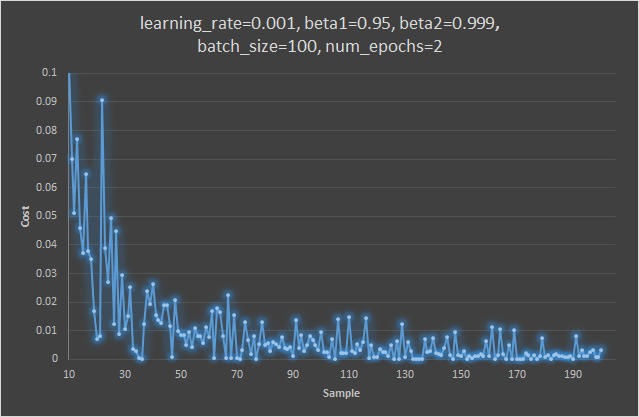 - Model v6 training results (100 sample images)

## Testing a Model

### Prediction Function

In [ ]:
# Make predictions with trained filters/weights
def Predict(image, _f1, _f2, _w3, _w4, _b1, _b2, _b3, _b4, c_stride=1, kernel_size=2, mp_stride=2):

    convolve_1 = Convolution_Forward(image, _f1, _b1, c_stride)  # 1st Convolution
    convolve_1[convolve_1 <= 0] = 0  # pass through ReLU Layer
    pooled_1 = Maxpooling_Forward(convolve_1, kernel_size, mp_stride)  # 1st Maxpooling

    convolve_2 = Convolution_Forward(pooled_1, _f2, _b2, c_stride)  # 2nd Convolution
    convolve_2[convolve_2 <= 0] = 0  # pass through ReLU Layer
    pooled_2 = Maxpooling_Forward(convolve_2, kernel_size, mp_stride)  # 2nd Maxpooling

    (p2_f, p2_dim, _) = pooled_2.shape
    Z1 = pooled_2.reshape((p2_f * p2_dim * p2_dim, 1))  # Flatten Maxpooled Layer
    Z = _w3.dot(Z1) + _b3  # 1st Dense Layer
    Z[Z <= 0] = 0  # pass through ReLU Layer
    out = _w4.dot(Z) + _b4  # 2nd Dense Layer

    _probability = Softmax_Activation(out)  # Predict class probability

    return np.argmax(_probability), np.max(_probability)

### Data extractions and testing process

In [ ]:
# Extract parameters from trained Model
parameters, cost = pickle.load(open('Aeroplane_Helicopter_v6.pkl', 'rb'))
[f1, f2, w3, w4, b1, b2, b3, b4] = parameters

# Obtain test images
img_input = []
file_aero = glob.glob("Aeroplane/Test_1/*.jpg")
file_heli = glob.glob("Helicopter/Test_1/*.jpg")
for fileA in file_aero:
    input_imageA = imageio.imread(fileA, as_gray=True)
    img_input.append([input_imageA, Image_Label(fileA)])
for fileH in file_heli:
    input_imageH = imageio.imread(fileH, as_gray=True)
    img_input.append([input_imageH, Image_Label(fileH)])

X = np.array([i[0] for i in img_input]).reshape(80, 1, 120, 120)  # Stores image data
X -= int(np.mean(X));   X /= int(np.std(X))  # Normalize the data
_labels = [i[1] for i in img_input]  # Stores image labels

correct = 0
print()
print("\nComputing accuracy over test set:")
t = tqdm(range(len(X)), leave=True)

for i in t:
    _X = X[i]
    prediction, probability = Predict(_X, f1, f2, w3, w4, b1, b2, b3, b4)
    if prediction == _labels[i]:
        correct += 1  # Count the number of correct predictions

    t.set_description("Accuracy:%0.2f%%" % (float(correct / (i + 1)) * 100))

print("Overall Accuracy: %.2f" % (float(correct / len(X) * 100)))

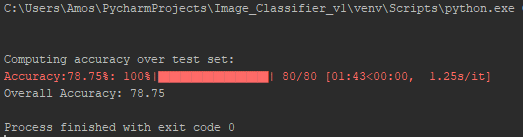 - Accuracy result using Model v6 (80 test images)